In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
import cv2
import multiprocessing
import numpy as np
import random
from tensorflow.keras import backend as K
import time

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2023-05-22 02:35:21.173762: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 02:35:21.210294: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 02:35:21.210754: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 02:35:21.743211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0
Num GPUs Available:  0


2023-05-22 02:35:22.595086: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-22 02:35:22.595291: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-22 02:35:22.596776: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the 

In [2]:
def readDataset(image_path):
    num_processes = 16
    with multiprocessing.Pool(processes=num_processes) as pool:
        results = pool.map(process_image, image_path)
    return results

def process_image(image_path):
    im = cv2.imread(image_path)
    # gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(im, (32, 32), interpolation=cv2.INTER_AREA)
    return resized

def load_dataset(train_image, train_label):
    train_image = readDataset(train_image)
    train_image = np.array(train_image)
    train_image = train_image/float(255)
    train_image -= np.mean(train_image)
    train_label = np.array(train_label)
    return (train_image, train_label)


def read_dataset(img_filename):
    filename = []
    label = []
    with open(img_filename, 'r') as f:
        for line in f.readlines():
            s = line.split(' ')
            filename.append(s[0])
            label.append(int(s[1]))
    dataset = []
    for i in range(len(filename)):
        dataset.append((filename[i],label[i]))   
    random.shuffle(dataset)    
    return dataset

In [3]:
dataset_train = read_dataset('train.txt')
dataset_test = read_dataset('test.txt')
dataset_val  = read_dataset('val.txt')

image_paths_train, Y_train = zip(*dataset_train)
image_paths_test, Y_test = zip(*dataset_test)
image_paths_val, Y_val = zip(*dataset_val)

(x_train, y_train) = load_dataset(image_paths_train, Y_train)
(x_test, y_test)   = load_dataset(image_paths_test, Y_test)
(x_valid, y_valid) = load_dataset(image_paths_val, Y_val)

In [4]:
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test  = tf.convert_to_tensor(x_test,  dtype=tf.float32)
x_valid = tf.convert_to_tensor(x_valid, dtype=tf.float32)
x_train.shape

TensorShape([63325, 32, 32, 3])

In [5]:
# Define the computational graph
inputs = tf.keras.Input(shape=x_train.shape[1:])
x = tf.keras.layers.Conv2D(6, 5, activation='tanh')(inputs)
x = tf.keras.layers.AveragePooling2D(2)(x)
x = tf.keras.layers.Activation('sigmoid')(x)
x = tf.keras.layers.Conv2D(16, 5, activation='tanh')(x)
x = tf.keras.layers.AveragePooling2D(2)(x)
x = tf.keras.layers.Activation('sigmoid')(x)
x = tf.keras.layers.Conv2D(120, 5, activation='tanh')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(84, activation='tanh')(x)
outputs = tf.keras.layers.Dense(50, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 activation (Activation)     (None, 14, 14, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                 

In [6]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()
layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 60)
print("Frozen model layers: ")
for layer in layers:
    print(layer)
print("-" * 60)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)

------------------------------------------------------------
Frozen model layers: 
x
model/conv2d/Conv2D/ReadVariableOp/resource
model/conv2d/BiasAdd/ReadVariableOp/resource
model/conv2d_1/Conv2D/ReadVariableOp/resource
model/conv2d_1/BiasAdd/ReadVariableOp/resource
model/conv2d_2/Conv2D/ReadVariableOp/resource
model/conv2d_2/BiasAdd/ReadVariableOp/resource
model/flatten/Const
model/dense/MatMul/ReadVariableOp/resource
model/dense/BiasAdd/ReadVariableOp/resource
model/dense_1/MatMul/ReadVariableOp/resource
model/dense_1/BiasAdd/ReadVariableOp/resource
model/conv2d/Conv2D/ReadVariableOp
model/conv2d/Conv2D
model/conv2d/BiasAdd/ReadVariableOp
model/conv2d/BiasAdd
model/conv2d/Tanh
model/average_pooling2d/AvgPool
model/activation/Sigmoid
model/conv2d_1/Conv2D/ReadVariableOp
model/conv2d_1/Conv2D
model/conv2d_1/BiasAdd/ReadVariableOp
model/conv2d_1/BiasAdd
model/conv2d_1/Tanh
model/average_pooling2d_1/AvgPool
model/activation_1/Sigmoid
model/conv2d_2/Conv2D/ReadVariableOp
model/conv2d_2/Co

2023-05-22 02:35:33.113657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-22 02:35:33.113913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-22 02:35:33.114048: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
2023-05-22 02:35:33.114133: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-22 02:35:33.233123: I tensorflow/compiler/xla/stream_executor/

In [7]:
start_time = time.time()

# compile and fit your model
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=2048, epochs=30, validation_data=(x_valid, y_valid))

end_time = time.time()

# calculate the total training time
total_time = end_time - start_time

# calculate the average time per epoch
avg_time_per_epoch = total_time / len(history.history['loss'])

print(f'Total training time: {total_time:.2f} seconds')
print(f'Average time per epoch: {avg_time_per_epoch:.2f} seconds')

Epoch 1/10
31/31 [==============================] - 4s 110ms/step - loss: 3.9238 - accuracy: 0.0197 - val_loss: 3.9200 - val_accuracy: 0.0200
Epoch 2/10
31/31 [==============================] - 3s 105ms/step - loss: 3.9144 - accuracy: 0.0196 - val_loss: 3.9196 - val_accuracy: 0.0200
Epoch 3/10
31/31 [==============================] - 3s 102ms/step - loss: 3.9134 - accuracy: 0.0217 - val_loss: 3.9170 - val_accuracy: 0.0356
Epoch 4/10
31/31 [==============================] - 3s 100ms/step - loss: 3.8961 - accuracy: 0.0274 - val_loss: 3.8631 - val_accuracy: 0.0489
Epoch 5/10
31/31 [==============================] - 3s 104ms/step - loss: 3.8001 - accuracy: 0.0418 - val_loss: 3.7486 - val_accuracy: 0.0467
Epoch 6/10
31/31 [==============================] - 3s 104ms/step - loss: 3.7392 - accuracy: 0.0539 - val_loss: 3.7118 - val_accuracy: 0.0600
Epoch 7/10
31/31 [==============================] - 3s 104ms/step - loss: 3.7095 - accuracy: 0.0598 - val_loss: 3.6712 - val_accuracy: 0.0756
Epoch 

In [8]:
from keras_flops import get_flops
# Calculae FLOPS
flops = get_flops(model)
print(f"FLOPS: {flops / 10e6} G")

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model g

2023-05-22 02:36:20.037470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-22 02:36:20.037711: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-22 02:36:20.037858: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
2023-05-22 02:36:20.037922: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-22 02:36:20.038392: I tensorflow/compiler/xla/stream_executor/

(0.0, 14.0)

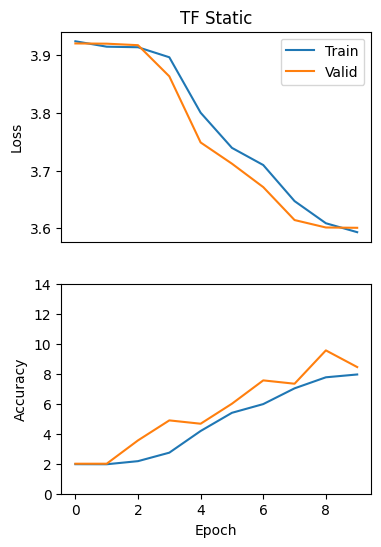

In [30]:
f = plt.figure(figsize=(4,6), dpi=100)
ax = f.add_subplot(211)
plt.title("TF Static")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel("Loss")
plt.xticks([])
plt.legend(['Train', 'Valid'])

ax = f.add_subplot(212)
plt.plot(np.array(history.history['accuracy'])*100)
plt.plot(np.array(history.history['val_accuracy'])*100)
# plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.ylim([0, 14])

plt.savefig('./pic/lenet5_tf_static.png')

In [11]:
start_time = time.time()
model.evaluate(x_test, y_test, batch_size=64)
end_time = time.time()
# calculate the total training time
total_time = end_time - start_time

15/15 [==============================] - 0s 2ms/step - loss: 3.5824 - accuracy: 0.0778


In [12]:
print(total_time)

0.06358933448791504


In [1]:
from keras_flops import get_flops
# Calculae FLOPS
flops = get_flops(model)
print(f"FLOPS: {flops / 10e6} G")

2023-05-26 07:30:06.091145: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-26 07:30:06.128392: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-26 07:30:06.128923: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 07:30:06.676170: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


NameError: name 'model' is not defined